<a href="https://colab.research.google.com/github/pavelpryadokhin/Classification/blob/main/writer_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Какой ты поэт?

Этот проект предлагает определить, с каким русским писателем вы больше всего похожи. Для этого достаточно просто загрузить ваш текст!

#Подготовка данных

In [ ]:
!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar
!pip install navec
! pip install razdel
from navec import Navec

navec = Navec.load('navec_hudlit_v1_12B_500K_300d_100q.tar')

Загрузим датасет датасет с писателями Русской литературы.

In [ ]:
import keras
data_path = keras.utils.get_file(
    "russian_literature.zip",
    "https://storage.yandexcloud.net/academy.ai/russian_literature.zip"
)

!unzip -qo "{data_path}" -d ./dataset



21547079/21547079 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
error:  cannot create ./dataset/poems/Blok/╨б╤В╨╕╤Е╨╛╤В╨▓╨╛╤А╨╡╨╜╨╕╤П 1897-1903 ╨│╨│, ╨╜╨╡ ╨▓╨╛╤И╨╡╨┤╤И╨╕╨╡ ╨▓ ╨╛╤Б╨╜╨╛╨▓╨╜╨╛╨╡ ╤Б╨╛╨▒╤А╨░╨╜╨╕╨╡.txt
        File name too long
error:  cannot create ./dataset/prose/Gogol/╨Я╨╛╨▓╨╡╤Б╤В╤М ╨╛ ╤В╨╛╨╝, ╨║╨░╨║ ╨┐╨╛╤Б╤Б╨╛╤А╨╕╨╗╤Б╤П ╨Ш╨▓╨░╨╜ ╨Ш╨▓╨░╨╜╨╛╨▓╨╕╤З ╤Б ╨Ш╨▓╨░╨╜╨╛╨╝ ╨Э╨╕╨║╨╕╤Д╨╛╤А╨╛╨▓╨╕╤З╨╡╨╝.txt
        File name too long
error:  cannot create ./dataset/publicism/Tolstoy/╨Ф╨╛╨║╨╗╨░╨┤, ╨┐╤А╨╕╨│╨╛╤В╨╛╨▓╨╗╨╡╨╜╨╜╤Л╨╣ ╨┤╨╗╤П ╨║╨╛╨╜╨│╤А╨╡╤Б╤Б╨░ ╨╛ ╨╝╨╕╤А╨╡ ╨▓ ╨б╤В╨╛╨║╨│╨╛╨╗╤М╨╝╨╡.txt
        File name too long
error:  cannot create ./dataset/publicism/Tolstoy/╨Я╨╛╤З╨╡╨╝╤Г ╤Е╤А╨╕╤Б╤В╨╕╨░╨╜╤Б╨║╨╕╨╡ ╨╜╨░╤А╨╛╨┤╤Л ╨▓╨╛╨╛╨▒╤Й╨╡ ╨╕ ╨▓ ╨╛╤Б╨╛╨▒╨╡╨╜╨╜╨╛╤Б╤В╨╕ ╤А╤Г╤Б╤Б╨║╨╕╨╣ ╨╜╨░╤Е╨╛╨┤╤П╤В╤Б╤П ╤В╨╡╨┐╨╡╤А╤М ╨▓ ╨▒╨╡╨┤╤Б╤В╨▓╨╡╨╜╨╜╨╛╨╝ ╨┐╨╛╨╗╨╛╨╢╨╡╨╜╨╕╨╕.txt
        File name too long


Отберем пять писателей, по которым будем проводить классификацию.

In [ ]:
CLASS_LIST=["Dostoevsky", "Tolstoy", 'Gorky', "Turgenev", 'Gogol']

In [ ]:
import glob

all_texts = {}  # Датасет в словаре

for author in CLASS_LIST:
    all_texts[author] = ''  # Инициализация нового ключа
    for path in glob.glob('./dataset/prose/{}/*.txt'.format(author)) + glob.glob('./dataset/poems/{}/*.txt'.format(author)):  # Поиск файлов
        with open(f'{path}', 'r', errors='ignore') as f:  # Игнорирование ошибок
            text = f.read()  # Содержимое файла

        all_texts[author] += ' ' + text.replace('\n', ' ')  # Замена переходов на пробелы


In [ ]:
from razdel import tokenize
from collections import Counter
from itertools import chain

embedding_dim = 300    # размерность векторов эмбединга (300d в имени эмбединга)
max_words = 10000      # Количество слов, рассматриваемых как признаки

all_words = []
for text in all_texts.values():
    tokens = [token.text for token in tokenize(text)]
    all_words.append(tokens)

word_counts = Counter(list(chain.from_iterable(all_words)))
vocab=dict()
ind=1
for (word, _) in word_counts.most_common(max_words):
    if word not in '!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff':
        vocab[word]=ind
        ind+=1

seq_train = []
for tokens in all_words:
    seq = []
    for word in tokens:
        if word in vocab:
            seq.append(vocab[word])
    seq_train.append(seq)


#Анализ данных

Общая выборка по писателям (по словам):
Датасет состоит из 3690445 слов
Dostoevsky - 1461792 слов, доля в общей базе: 39.61%
Tolstoy - 1172151 слов, доля в общей базе: 31.76%
Gorky - 514678 слов, доля в общей базе: 13.95%
Turgenev - 283905 слов, доля в общей базе: 7.69%
Gogol - 257919 слов, доля в общей базе: 6.99%
Среднее значение слов:  738089.0
Медианное значение слов:  514678.0


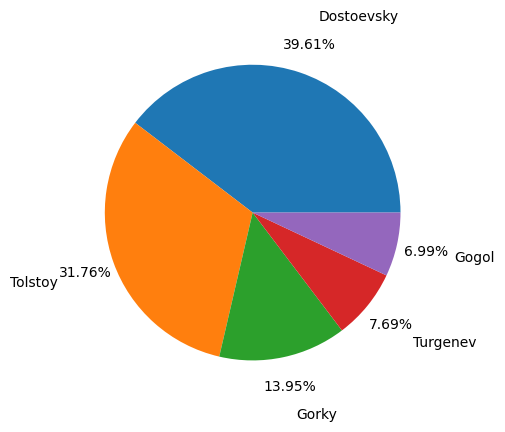

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

print('Общая выборка по писателям (по словам):')
mean_list = np.array([])
total = sum(len(i) for i in seq_train)
print(f'Датасет состоит из {total} слов')
for author in CLASS_LIST:
    cls = CLASS_LIST.index(author)
    print(f'{author} - {len(seq_train[cls])} слов, доля в общей базе: {len(seq_train[cls])/total*100 :.2f}%')
    mean_list = np.append(mean_list, len(seq_train[cls]))

print('Среднее значение слов: ', np.round(mean_list.mean()))
print('Медианное значение слов: ', np.median(mean_list))

fig, ax = plt.subplots()
ax.pie([len(i) for i in seq_train],
       labels=CLASS_LIST,
       pctdistance=1.2,
       labeldistance=1.4,
       autopct='%1.2f%%'
      )
plt.show()

In [ ]:
median = int(np.median(mean_list))
CLASS_LIST_BALANCE = []
seq_train_balance = []
for author in CLASS_LIST:
    cls = CLASS_LIST.index(author)
    seq_train_balance.append(seq_train[cls][:324000])
    CLASS_LIST_BALANCE.append(author)

Сбалансированная выборка по писателям (по словам):
Dostoevsky - 324000 слов, доля в общей базе: 21.40%
Tolstoy - 324000 слов, доля в общей базе: 21.40%
Gorky - 324000 слов, доля в общей базе: 21.40%
Turgenev - 283905 слов, доля в общей базе: 18.75%
Gogol - 257919 слов, доля в общей базе: 17.04%
Среднее значение слов:  302765.0
Медианное значение слов:  324000.0


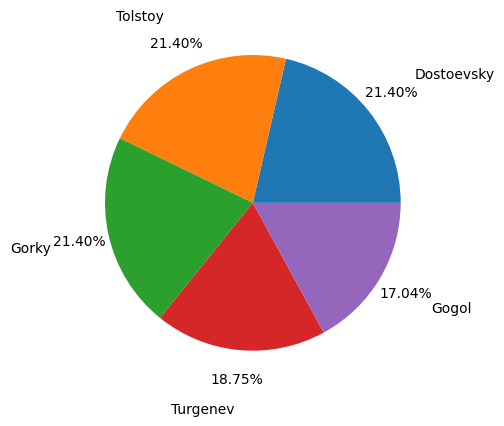

In [ ]:
total = sum(len(i) for i in seq_train_balance)

print('Сбалансированная выборка по писателям (по словам):')
mean_list_balance = np.array([])
for author in CLASS_LIST_BALANCE:
    cls = CLASS_LIST_BALANCE.index(author)
    print(f'{author} - {len(seq_train_balance[cls])} слов, доля в общей базе: {len(seq_train_balance[cls])/total*100 :.2f}%')
    mean_list_balance = np.append(mean_list_balance, len(seq_train_balance[cls]))

print('Среднее значение слов: ', np.round(mean_list_balance.mean()))
print('Медианное значение слов: ', np.median(mean_list_balance))

fig, ax = plt.subplots()
ax.pie([len(i) for i in seq_train_balance],
       labels=CLASS_LIST_BALANCE,
       pctdistance=1.2,
       labeldistance=1.4,
       autopct='%1.2f%%'
      )
plt.show()

#Постобработка данных

In [ ]:
WIN_SIZE = 1000   # Ширина окна в токенах
WIN_STEP = 100    # Шаг окна в токенах

# Функция разбиения последовательности на отрезки скользящим окном
# Последовательность разбивается на части до последнего полного окна
# Параметры:
# sequence - последовательность токенов
# win_size - размер окна
# step - шаг окна
def seq_split(sequence, win_size, step):
    # Делим строку на отрезки с помощью генератора цикла
    return [sequence[i:i + win_size] for i in range(0, len(sequence) - win_size + 1, step)]

def seq_vectorize(
    seq_list,   # Последовательность
    val_split,   # Доля на валидационную выборку
    test_split, # Доля на тестовую сборку
    class_list, # Список классов
    win_size,   # Ширина скользящего окна
    step        # Шаг скользящего окна
):

    # Списки для результирующих данных
    x_train, y_train, x_val, y_val, x_test, y_test =  [], [], [], [], [], []

    # Пробежимся по всем классам:
    for class_item in class_list:
        # Получим индекс класса
        cls = class_list.index(class_item)

        # Пороговое значение индекса для разбивки на тестовую и обучающую выборки
        gate_split_1 = int(len(seq_list[cls]) * (1-test_split-val_split))
        gate_split_2 = int(len(seq_list[cls]) * (1-test_split))

        # Разбиваем последовательность токенов класса на отрезки
        vectors_train = seq_split(seq_list[cls][:gate_split_1], win_size, step) # последовательность до порога попадет в обучающую выборку
        vectors_val = seq_split(seq_list[cls][gate_split_1:gate_split_2], win_size, step)
        vectors_test = seq_split(seq_list[cls][gate_split_2:], win_size, step)  # последовательность после порога попадет в тестовую выборку

        # Добавляем отрезки в выборку
        x_train += vectors_train
        x_val += vectors_val
        x_test += vectors_test

        # Для всех отрезков класса добавляем метки класса в виде one-hot-encoding
        # Каждую метку берем len(vectors) раз, так она одинакова для всех выборок одного класса
        y_train += [keras.utils.to_categorical(cls, len(class_list))] * len(vectors_train)
        y_val += [keras.utils.to_categorical(cls, len(class_list))] * len(vectors_val)
        y_test += [keras.utils.to_categorical(cls, len(class_list))] * len(vectors_test)

    # Возвращаем результатов как numpy-массивов
    return np.array(x_train), np.array(y_train),np.array(x_val), np.array(y_val), np.array(x_test), np.array(y_test)

In [ ]:
x_train, y_train, x_val, y_val, x_test, y_test = seq_vectorize(seq_train_balance, 0.1, 0.1, CLASS_LIST, WIN_SIZE, WIN_STEP)

print(f'Форма входных данных для обучающей выборки: {x_train.shape}')
print(f'Форма выходных данных (меток) для обучающей выборки: {y_train.shape}')
print(f'Форма входных данных для тестовой выборки: {x_test.shape}')
print(f'Форма выходных данных (меток) для тестовой выборки: {y_test.shape}')
print(x_val.shape,y_val.shape)

Форма входных данных для обучающей выборки: (12065, 1000)
Форма выходных данных (меток) для обучающей выборки: (12065, 5)
Форма входных данных для тестовой выборки: (1467, 1000)
Форма выходных данных (меток) для тестовой выборки: (1467, 5)
(1467, 1000) (1467, 5)


#Обучение

In [ ]:
import numpy as np

def loadEmbedding(model):
    # word_index = tokenizer.word_index #исходный вариант
    word_index = vocab
    embeddings_index = navec

    embedding_matrix = np.zeros((max_words, embedding_dim))
    for word, i in word_index.items():
        if i < max_words:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector

    model.layers[0].build((None, WIN_SIZE))
    model.layers[0].set_weights([embedding_matrix])
    model.layers[0].trainable = False
    return model

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, Dense, SpatialDropout1D, BatchNormalization, Dropout,GRU,LSTM

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=WIN_SIZE))
model.add(SpatialDropout1D(0.3))
model.add(BatchNormalization())

# Два двунаправленных рекуррентных слоя LSTM
model.add(Bidirectional(LSTM(8, return_sequences=True)))
model.add(Bidirectional(LSTM(8, return_sequences=True)))
model.add(Dropout(0.3))
model.add(BatchNormalization())

# Два рекуррентных слоя GRU
model.add(GRU(16, return_sequences=True, reset_after=True))
model.add(GRU(16, reset_after=True))
model.add(Dropout(0.3))
model.add(BatchNormalization())

# Дополнительный полносвязный слой
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(len(CLASS_LIST_BALANCE), activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
model = loadEmbedding(model)

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(filepath = 'best_model.keras',
                             monitor = 'val_accuracy',
                             save_best_only = True,
                             mode = 'max',
                             verbose = 0),
]


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=50, batch_size=128, validation_data=(x_val, y_val),callbacks=callbacks)

Epoch 1/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 27s 214ms/step - accuracy: 0.2002 - loss: 2.0246 - val_accuracy: 0.1575 - val_loss: 1.6071
Epoch 2/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 19s 196ms/step - accuracy: 0.2226 - loss: 1.7776 - val_accuracy: 0.1963 - val_loss: 1.6039
Epoch 3/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 20s 195ms/step - accuracy: 0.2501 - loss: 1.6858 - val_accuracy: 0.2945 - val_loss: 1.5822
Epoch 4/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 20s 189ms/step - accuracy: 0.2968 - loss: 1.5917 - val_accuracy: 0.3129 - val_loss: 1.5547
Epoch 5/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 21s 192ms/step - accuracy: 0.3477 - loss: 1.5118 - val_accuracy: 0.3661 - val_loss: 1.6081
Epoch 6/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 20s 190ms/step - accuracy: 0.3999 - loss: 1.4278 - val_accuracy: 0.3620 - val_loss: 1.5118
Epoch 7/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 20s 187ms/step - accuracy: 0.4093 - loss: 1.4045 - val_accuracy: 0.4274 - val_loss: 1.4655
Epoch 8/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 18s 194ms/step - accuracy: 0.4395 - loss: 1.3554 - val_accu

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Вывод графиков точности и ошибки
def show_plot(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
    fig.suptitle('График процесса обучения модели')
    ax1.plot(history.history['accuracy'],
               label='График точности на обучающей выборке')
    ax1.plot(history.history['val_accuracy'],
               label='График точности на проверочной выборке')
    ax1.xaxis.get_major_locator().set_params(integer=True)
    ax1.set_xlabel('Эпоха обучения')
    ax1.set_ylabel('График точности')
    ax1.legend()

    ax2.plot(history.history['loss'],
               label='Ошибка на обучающей выборке')
    ax2.plot(history.history['val_loss'],
               label='Ошибка на проверочной выборке')
    ax2.xaxis.get_major_locator().set_params(integer=True)
    ax2.set_xlabel('Эпоха обучения')
    ax2.set_ylabel('Ошибка')
    ax2.legend()
    plt.show()

# Функция вывода предсказанных значений
def show_confusion_matrix(y_true, y_pred, class_labels):
    cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
    cm = np.around(cm, 3)

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title(f'Матрица ошибок', fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax)
    plt.gca().images[-1].colorbar.remove()
    plt.xlabel('Предсказанные классы', fontsize=16)
    plt.ylabel('Верные классы', fontsize=16)
    fig.autofmt_xdate(rotation=45)
    plt.show()

    print('\nСредняя точность распознавания: {:3.0f}%'.format(100. * cm.diagonal().mean()))


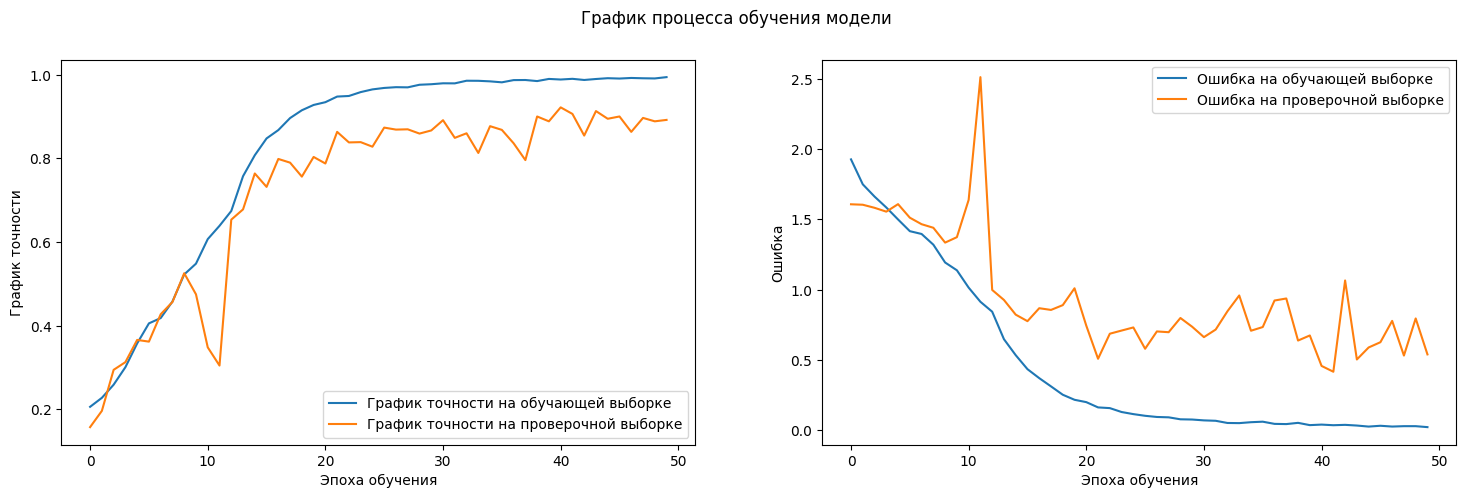

In [ ]:
show_plot(history)

In [ ]:
model = keras.saving.load_model('best_model.keras')

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(filepath = 'best_model.keras',
                             monitor = 'val_accuracy',
                             save_best_only = True,
                             mode = 'max',
                             verbose = 0),
]


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_data=(x_val, y_val),callbacks=callbacks)

Epoch 1/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 30s 233ms/step - accuracy: 0.9893 - loss: 0.0454 - val_accuracy: 0.8466 - val_loss: 1.1218
Epoch 2/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 38s 202ms/step - accuracy: 0.9889 - loss: 0.0378 - val_accuracy: 0.9196 - val_loss: 0.5259
Epoch 3/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 19s 188ms/step - accuracy: 0.9902 - loss: 0.0337 - val_accuracy: 0.8309 - val_loss: 1.1941
Epoch 4/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 21s 194ms/step - accuracy: 0.9869 - loss: 0.0432 - val_accuracy: 0.9148 - val_loss: 0.5922
Epoch 5/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 22s 212ms/step - accuracy: 0.9863 - loss: 0.0548 - val_accuracy: 0.9093 - val_loss: 0.4437
Epoch 6/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 18s 190ms/step - accuracy: 0.9921 - loss: 0.0324 - val_accuracy: 0.9237 - val_loss: 0.4155
Epoch 7/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 21s 194ms/step - accuracy: 0.9934 - loss: 0.0254 - val_accuracy: 0.9332 - val_loss: 0.4435
Epoch 8/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 20s 192ms/step - accuracy: 0.9958 - loss: 0.0189 - val_accu

46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step


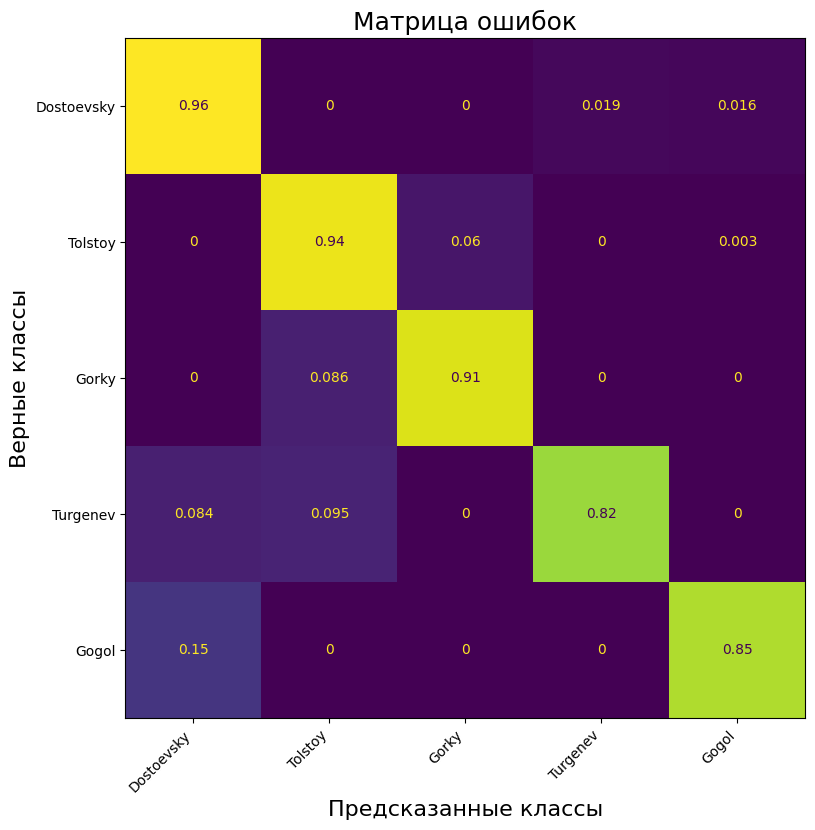


Средняя точность распознавания:  90%


In [ ]:
y_pred = model.predict(x_test)
show_confusion_matrix(y_test, y_pred, CLASS_LIST_BALANCE)

In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Точность на тестовом образце:', test_acc)
print('Потери на тестовом образце:', test_loss)

46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.9454 - loss: 0.3690
Точность на тестовом образце: 0.9018405079841614
Потери на тестовом образце: 0.6820893287658691


#Прогноз писателя

In [ ]:
from keras.preprocessing.sequence import pad_sequences

mytext=''
path='/content/Text.txt'
with open(f'{path}', 'r', errors='ignore') as f:
        text = f.read()
        mytext = text.replace('\n', ' ')

def predict_text(text):
  tokens = [token.text for token in tokenize(text)]
  seq = []
  for word in tokens:
      if word in vocab:
          seq.append(vocab[word])
  test_text = pad_sequences([seq], WIN_SIZE)
  predictions = model.predict(test_text)
  return predictions[0]



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 760ms/step


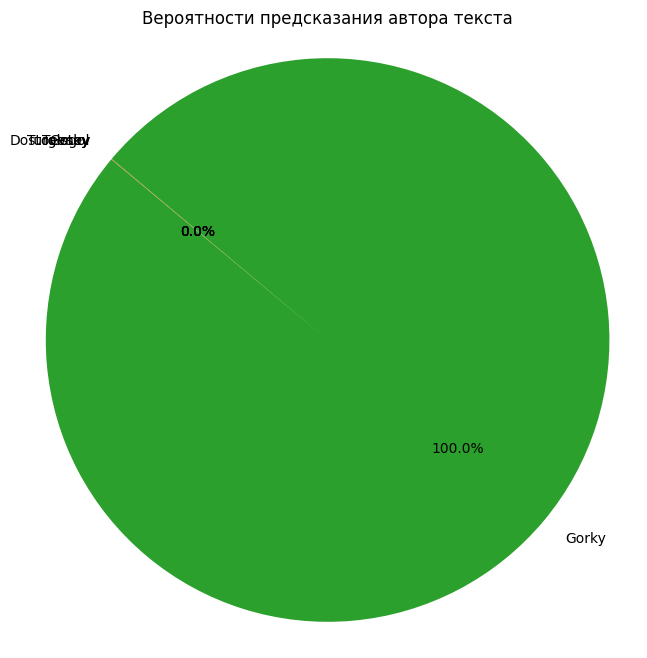

In [ ]:
result= predict_text(mytext)
plt.figure(figsize=(8, 8))
plt.pie(result, labels=CLASS_LIST, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title("Вероятности предсказания автора текста")
plt.show()